# Weights of Evidence 
Теоретические заметки по методу, называемому Weights of Evidence.

Концепция и суть метода, а так же его создатели к сожалению "утеряны" в веках. 
Часть научных работ нуждается в анализе для более полного понимания. 

Для общего понимания, метод Weights Of Evidence состоит в очень простой идее.  
Рассмотрим одномерный случай зависимости между вектором $X$ и бинарной переменной $y$. 
Суть метода состоит в том, чтобы таким образом преобразовать переменную $X$, 
чтобы получить гораздо более удобное представление информации для модели. 
Само по себе преобразование делает следующее:
1. Мы разбиваем вектор $X$ на $n$-групп (равномерно или нет, как выбрать $n$ оптимально - это открытые вопросы).
2. Для каждой группы $X_i , i\in\ (1,...,n)$  мы рассчитываем три величины:
 - Доля объектов выборки при которых y=0 от общего количества объектов y=0 (иначе - Non Events - NE):  
    $ NE_i = \frac {n(y_i=0)}{n(y=0)}$
 - Доля объектов выборки при которых y=1 от общего количества объектов y=1 (иначе - Events - E):  
    $ E_i = \frac {n(y_i=1)}{n(y=1)}$
 - Величина WoE:  
    $WoE_i = \ln( \frac {NE_i}{E_i} )$  

Таким образом мы получаем довольно интересное преобразование, которое в своей основе оперирует распределениями первого ( $P(X[y=0])$ ) и второго ( $P(X[y=1])$ ) классов в задаче. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Модельный пример
Рассмотрим базовую задачу логистической регрессии, где необходимо разделить два класса.  
Оба класса сгенерированы из двумерного случайного распределения:
- первый с параметрами $(\mu=0,\sigma^2=1)$
- второй с параметрами $(\mu=2,\sigma^2=1)$  

Создадим набор данных с количеством записей в каждом классе = 1000. 
Выделим тестовое множество размером 30%. 

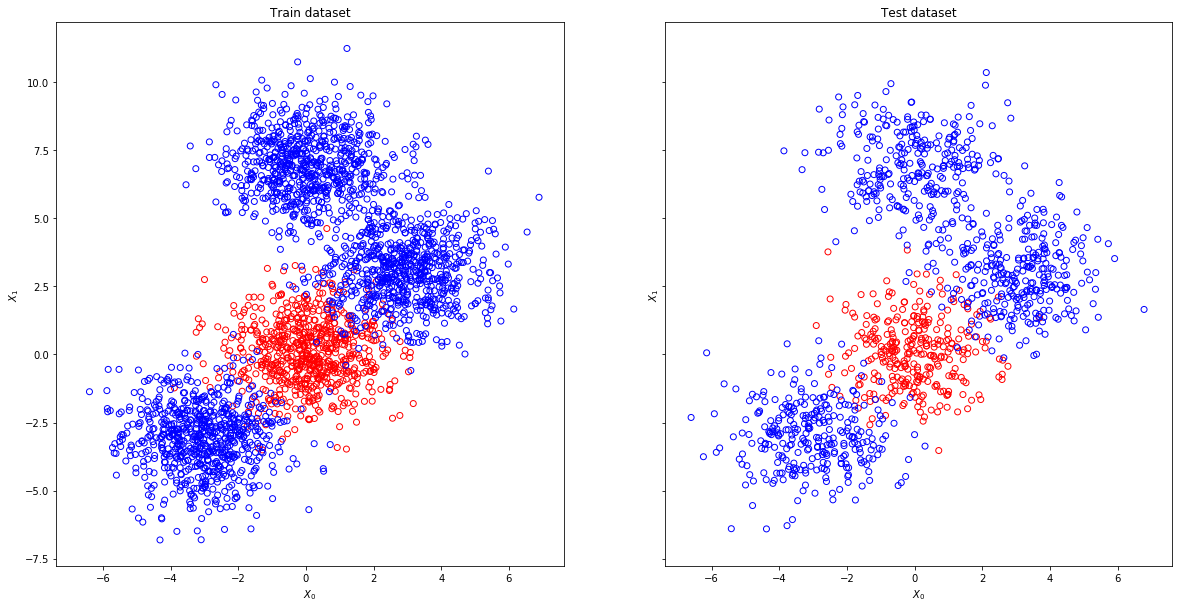

In [5]:
np.random.seed(42)
N_ELEMENTS = 1000
d0 = pd.DataFrame(np.random.normal(0,1.2,size=(N_ELEMENTS,2)),columns=['X0','X1'])
d0['y'] = 1
d1 = pd.DataFrame(np.random.normal(3,1.2,size=(N_ELEMENTS,2)),columns=['X0','X1'])
d1['y'] = 0
d2 = pd.DataFrame(np.random.normal(-3,1.2,size=(N_ELEMENTS,2)),columns=['X0','X1'])
d2['y'] = 0
d3 = pd.DataFrame(np.random.normal(0,1.2,size=(N_ELEMENTS,2)),columns=['X0','X1'])
d3['X1'] = d3['X1'] + 7
d3['y'] = 0
d_all = pd.concat([d0,d1,d2,d3],axis=0)
X_train,X_test,y_train,y_test = train_test_split(d_all[['X0','X1']],d_all['y'],random_state=42,test_size=0.3)

f, (ax1, ax2) = plt.subplots(ncols=2,sharex=True,sharey=True,figsize=(20,10))
# plot train
ax1.scatter(X_train[y_train == 1]['X0'],X_train[y_train == 1]['X1'],facecolors='none', edgecolors='r')
ax1.scatter(X_train[y_train == 0]['X0'],X_train[y_train == 0]['X1'],facecolors='none', edgecolors='b')
ax1.set_title('Train dataset')
ax1.set_xlabel('$X_0$')
ax1.set_ylabel('$X_1$')

# plot test

ax2.scatter(X_test[y_test == 1]['X0'],X_test[y_test == 1]['X1'],facecolors='none', edgecolors='r')
ax2.scatter(X_test[y_test == 0]['X0'],X_test[y_test == 0]['X1'],facecolors='none', edgecolors='b')
ax2.set_title('Test dataset')
ax2.set_xlabel('$X_0$')
ax2.set_ylabel('$X_1$')
print()

# Рассмотрим распределение переменных 
Для классов $X[y=0]$ и $X[y=1]$ построим распределение плотности вероятности

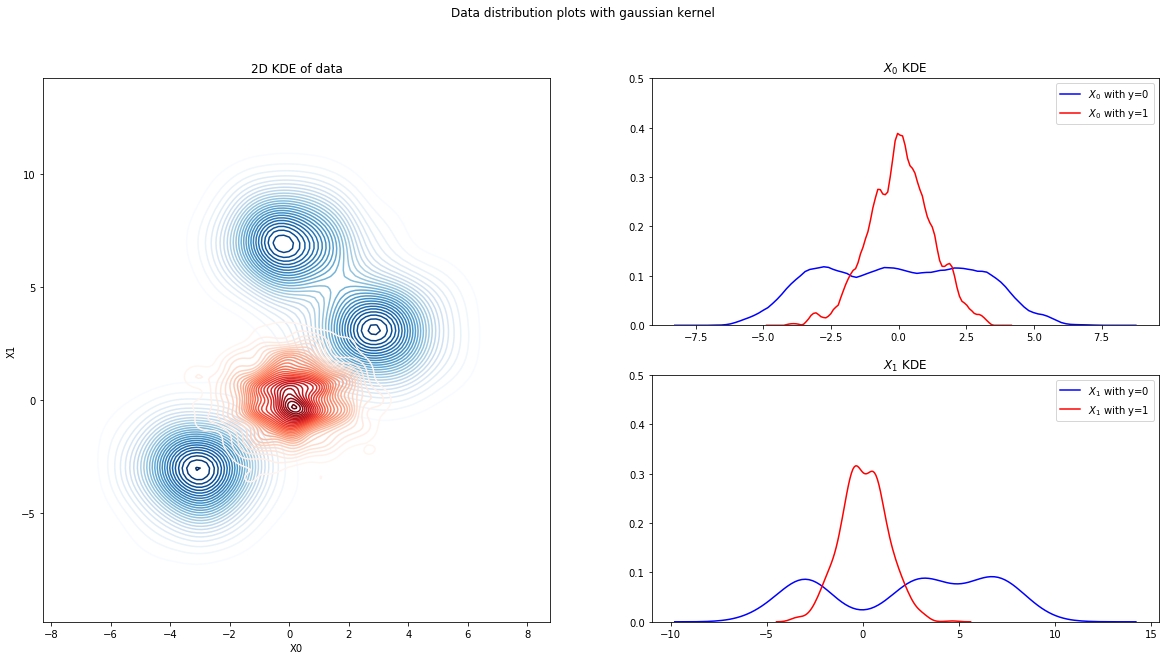

In [6]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(222)
ax1.set_title('$X_0$ KDE')
# plot X0
sns.kdeplot(X_train[y_train == 0]['X0'],color='blue',label='$X_0$ with y=0',ax=ax1,kernel='epa')
sns.kdeplot(X_train[y_train == 1]['X0'],color='red',label='$X_0$ with y=1',ax=ax1,kernel='epa')
ax1.set_ylim((0,.5))
# plot X1
ax2 = fig.add_subplot(224)
ax2.set_title('$X_1$ KDE')
sns.kdeplot(X_train[y_train == 0]['X1'],color='blue',label='$X_1$ with y=0',ax=ax2)
sns.kdeplot(X_train[y_train == 1]['X1'],color='red',label='$X_1$ with y=1',ax=ax2)
ax2.set_ylim((0,.5))
ax3 = fig.add_subplot(121)
ax3.set_title('2D KDE of data')
sns.kdeplot(X_train[y_train == 0]['X0'],X_train[y_train == 0]['X1'],kernel='epa',ax=ax3,cmap="Blues",shade_lowest=False,n_levels=30)
sns.kdeplot(X_train[y_train == 1]['X0'],X_train[y_train == 1]['X1'],kernel='epa',ax=ax3,cmap="Reds",shade_lowest=False,n_levels=30)
#fig.tight_layout()
fig.suptitle('Data distribution plots with gaussian kernel')
print()

Далее, рассчитаем по ним величину $WoE$, положив $n=10$  
Для начала, рассчитаем бины:

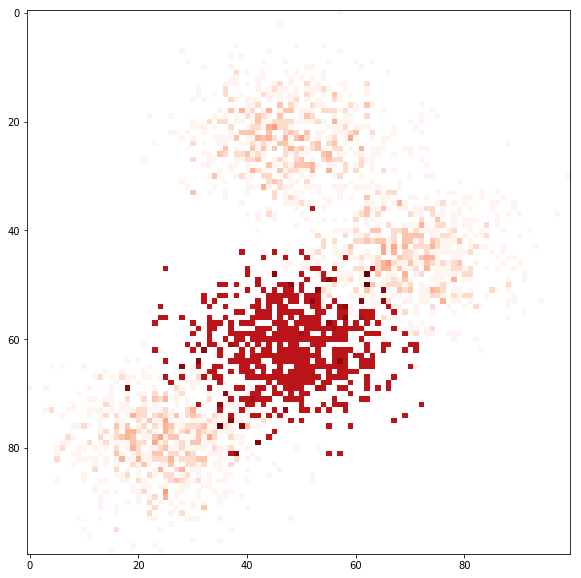

In [43]:
from scipy.stats import binned_statistic_2d

def calculate_woe(y,total_good,total_bad):
    e_i = y.sum()/np.float(total_good)
    e_i = 0.1 if e_i==0 else e_i
    ne_i = (len(y) - e_i)/np.float(total_bad)
    ne_i = 0.1 if ne_i==0 else ne_i
    g_size = len(y)
    woe_v = np.log(ne_i/e_i)
    return woe_v

TOTAL_GOOD = y_train.sum()
TOTAL_BAD = len(y_train) - y_train.sum()

binning_result = binned_statistic_2d(x=X_train['X0'].values,y=X_train['X1'].values,values=y_train,bins=100,
                                     statistic=lambda y:calculate_woe(y,TOTAL_GOOD,TOTAL_BAD))
figure = plt.figure(figsize=(10,10))
ax = figure.add_subplot(111)
ax.imshow(
    np.rot90(binning_result.statistic),
    cmap='Reds'
)